In [ ]:
#google colab drive mount code

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# importing required libraries.
!pip install scikit-learn
!pip install keras
!pip install keras_flops
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score

import pickle

In [ ]:
# Load the datasets
with open('/content/gdrive/MyDrive/Fake News/Model/Data/korean_CNN_Dataset_1_Atten.pkl', 'rb') as f:
    x_train, y_train, x_test, y_test, x_val, y_val, word_index = pickle.load(f)

In [ ]:
x_train.shape

(20494, 700)

In [ ]:
x_val.shape

(3617, 700)

In [ ]:
x_test.shape

(6028, 700)

In [ ]:
# building convolutional neural network model                                                                      
from keras.layers.reshaping.flatten import Flatten
from keras.layers.pooling.max_pooling1d import MaxPool1D
from keras.models import Sequential, Model
from keras.layers import Embedding, Conv1D, Dense, Dropout, multiply, Permute, Lambda
from keras import backend as K

In [ ]:
# Defining the model architecture
model = Sequential()
# part 1: word and sequence processing
     
# defining embedding layer where embedding dimension/ vector size is defined as 64 and input length is set as 700. Where num_words are unique words.

model.add(Embedding(input_dim =len(word_index),
                         output_dim = 64, 
                         input_length= 700))
# for defining convolutional layer, number of filters are set as 32 and kernal size is defined as 1 X 5.
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
# maxpooling1d layer is used to take maximum values from representation.
model.add(MaxPool1D(2))
# adding droppout of 0.4
model.add(Dropout(rate=0.4))

# creating second convolutional layer with kernal size 1 X 3, and number of filters will be 16. Where activation function will remain same as ReLU.
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
# creating maxpooling layer with 2 neurons so that will compare with neighbour neuron and will take max value and also setting strides value as 2.
model.add(MaxPool1D(2, strides=2))

# adding one more convolutional layer with kernal size 1 X 3, and number of filters will be 8 and setting strides value as 2. Where activation function will be ReLU.
model.add(Conv1D(filters=8, kernel_size=3, activation='relu', strides= 2))
# adding flatten layer
model.add(Flatten())

# adding dense layer with 512 neurons.
model.add(Dense(units=512, activation='relu'))
# adding dropout value of 0.5
model.add(Dropout(rate=0.5))


# Adding attention matrix to the model
attention_probs = Dense(512, activation='softmax', name='attention_probs')(model.layers[-1].output)
attention_mul = multiply([model.layers[-1].output, attention_probs], name='attention_mul')
output_attention = Lambda(lambda x: K.sum(x, axis=1), name='output_attention')(attention_mul)

# output layer contains 1 value because this is binary classification problem.
# Where activation function is 'sigmoid'.
        
model.add(Dense(units=1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 64)           10190272  
                                                                 
 conv1d (Conv1D)             (None, 696, 32)           10272     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 348, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 348, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 346, 16)           1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 173, 16)          0         
 1D)                                                    

In [ ]:
# train the model
import time as t
start = t.time()
history = model.fit(x_train, 
                    y_train,
                    batch_size=128,
                    epochs=15,
                    validation_data=(x_val, y_val))
print("total time in training",t.time()-start)

Epoch 1/15
161/161 [==============================] - 115s 652ms/step - loss: 0.6564 - accuracy: 0.5772 - val_loss: 0.5888 - val_accuracy: 0.6992
Epoch 2/15
161/161 [==============================] - 95s 593ms/step - loss: 0.4550 - accuracy: 0.7863 - val_loss: 0.5242 - val_accuracy: 0.7293
Epoch 3/15
161/161 [==============================] - 97s 602ms/step - loss: 0.2126 - accuracy: 0.9192 - val_loss: 0.6262 - val_accuracy: 0.7235
Epoch 4/15
161/161 [==============================] - 95s 592ms/step - loss: 0.1134 - accuracy: 0.9613 - val_loss: 0.6831 - val_accuracy: 0.7343
Epoch 5/15
161/161 [==============================] - 106s 654ms/step - loss: 0.0760 - accuracy: 0.9716 - val_loss: 0.7325 - val_accuracy: 0.7221
Epoch 6/15
161/161 [==============================] - 100s 621ms/step - loss: 0.0555 - accuracy: 0.9755 - val_loss: 0.8957 - val_accuracy: 0.7230
Epoch 7/15
161/161 [==============================] - 98s 611ms/step - loss: 0.0428 - accuracy: 0.9769 - val_loss: 0.8870 - val

In [ ]:
get_ipython().system('pip install keras_flops')
import keras_flops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

In [ ]:
def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops

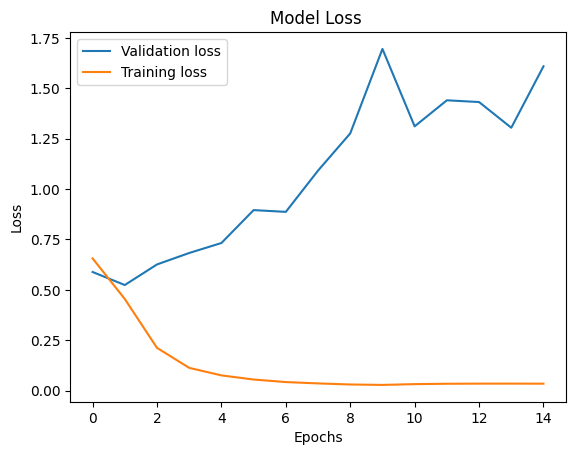

In [ ]:
# Plot training & validation Loss

plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss ')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Validation loss', 'Training loss'], loc='upper left')
plt.show()
# plt.savefig('korean_CNN_Output/Images/loss_korean_1.png', bbox_inches='tight')

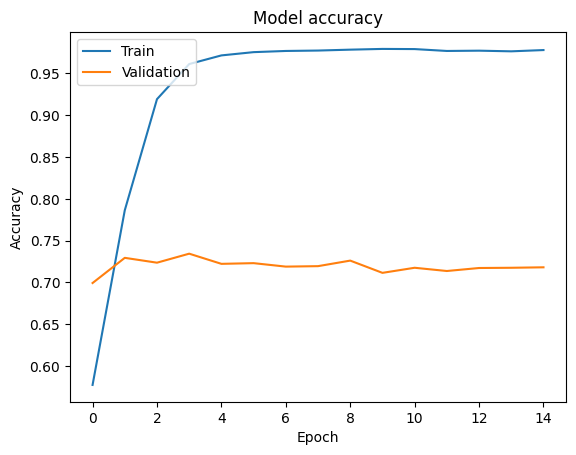

In [ ]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# plt.savefig('korean_CNN_Output/Images/accuracy_korean_1.png', bbox_inches='tight')

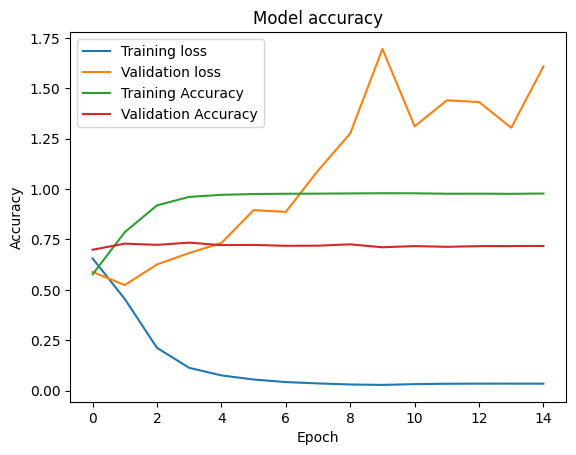

In [ ]:
# Plot accuracy and loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(results['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss','Training Accuracy','Validation Accuracy'], loc='upper left')
plt.show()
# plt.savefig('korean_CNN_Output/Images/mix_korean_1.png', bbox_inches='tight')

In [ ]:
# define a function that allows us to evaluate models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing accuraries are reported
    '''
    # training acc
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing acc
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    

    # accuracy = accuracy_score(y_test,y_pred_tex)
    roc_auc =roc_auc_score(y_test, y_predict_test)
    precision = precision_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    recall = recall_score(y_pred=y_predict_test, y_true=y_test,zero_division=1)
    
    cr = classification_report(y_test, y_predict_test,zero_division=1)


    fpr, tpr, threshold = roc_curve(y_test, y_predict_test)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label= 'CNN')
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title('%s ROC Curve'% 'CNN',fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

    roc_auc_sc = roc_auc_score(y_test,y_predict_test)

    return train_acc, test_acc,cr,roc_auc_sc


189/189 [==============================] - 4s 21ms/step


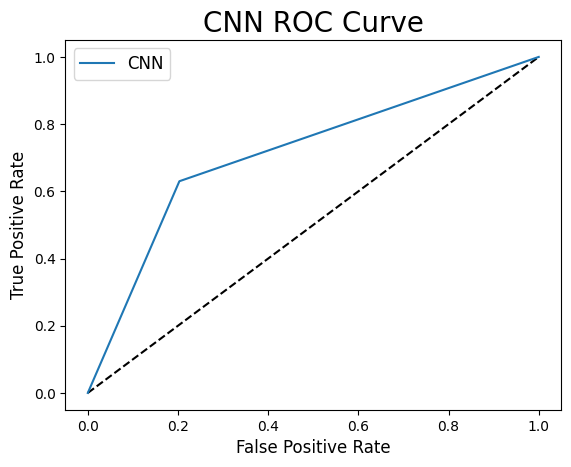

Training Accuracy: 98.17%
Testing Accuracy: 71.88%
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.80      0.75      3206
           1       0.73      0.63      0.68      2822

    accuracy                           0.72      6028
   macro avg       0.72      0.71      0.71      6028
weighted avg       0.72      0.72      0.72      6028

AUC score 0.713496420823288
Total testing time: 19.30218505859375


In [ ]:
# evaluate model
import time as t
start = t.time()
train_acc, test_acc,cr,roc_auc_sc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train, 
                                     y_train, 
                                     x_test, 
                                     y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))
print("Classification Report:\n",cr)
print("AUC score",roc_auc_sc)
print("Total testing time:",t.time()-start)